In [34]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import Categorical
from IPython.display import clear_output

In [49]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('episode %s. reward: %s' % (frame_idx, np.mean(rewards[-100:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

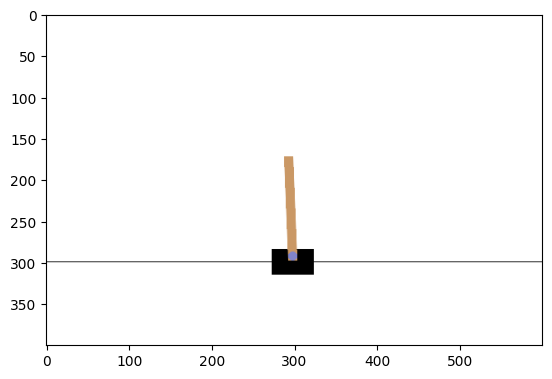

In [4]:
env = gym.make('CartPole-v1',render_mode = 'rgb_array')
state,info = env.reset()
plt.imshow(env.render())
plt.show()

In [5]:
class A_C(nn.Module):
    def __init__(self, state_shape,n_actions):
        super(A_C,self).__init__()
        
        self.f = nn.Sequential(
            nn.Linear(state_shape,64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU()
        )
        self.critic = nn.Linear(64,1)
        self.actor = nn.Linear(64,n_actions)
        
    def forward(self,x):
        x = self.f(x)
        value = self.critic(x)
        action_prob = F.softmax(self.actor(x),dim=-1)
        pmf = Categorical(action_prob)
        return pmf,value

In [52]:
Agent = A_C(4,2).to(device)
optimizer = torch.optim.Adam(Agent.parameters(),lr = 5e-4)

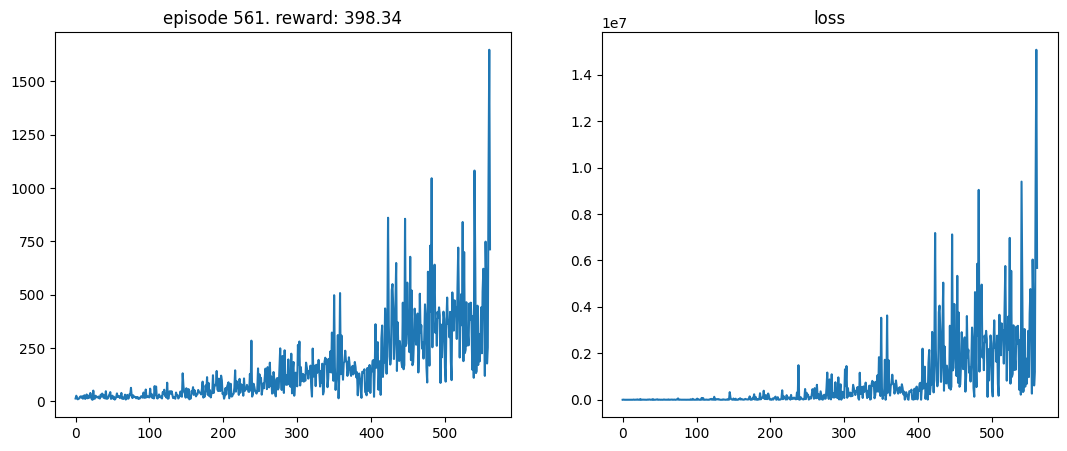

Solvaed


In [53]:
n_steps = 1000
episods_rewards = []
losses = []
for i in range(n_steps):
    state,info = env.reset()
    returns = []
    rewards = []
    values = []
    log_probs = []
    dones = []
    entropy = 0
    
    
    while True:
        state = torch.from_numpy(state).unsqueeze(dim=0).to(device)
        pmf,value = Agent(state)
        action = pmf.sample()
        next_state,reward,done,_,info = env.step(action.item())
        log_prob = pmf.log_prob(action)
        entropy += pmf.entropy().mean()
        rewards.append(reward)
        values.append(value)
        dones.append(done)
        log_probs.append(log_prob)
        if done:
            break
        state = next_state
    episods_rewards.append(sum(rewards))
    g = 0    
    for r in rewards[::-1]:
        g = r + 0.99 * g
        returns.insert(0,g)
    
    #returns = torch.tensor(returns)
    actor_loss = []
    critic_loss = []
    
    for log_p,value,r in zip(log_probs,values,returns):
        advantage = r - value.item()
        actor_loss.append(-(log_p * advantage))
        critic_loss.append(torch.tensor(advantage,dtype=torch.float32).pow(2))
        
    optimizer.zero_grad()
    loss = torch.stack(actor_loss).sum() + torch.stack(critic_loss).sum()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    plot(i,episods_rewards,losses)
    if np.mean(episods_rewards[-100:]) > 400:
        print('Solvaed')
        break
    
    